# Задача

В рамках данного учебного соревнования вам предстоит построить модель, классифицирующую изображения с одеждой, которая построена на датасете **Fashion-MNIST**. 

**Fashion-MNIST** — аналог знаменитого датасета MNIST, который состоит не из рукописных символов, а из предметов одежды. Он был создан, чтобы актуализировать учебные задачи в компьютерном зрении и приблизить их к реальности.

Решение более сложной постановки этой задачи может использоваться, например, в маркетплейсах. Покупателю могут рекомендоваться товары по изображениям в соответствии с введенным описанием. Продавцу при загрузке изображений в карточку товара могут автоматически рекомендоваться теги и описание предмета одежды.

Каждое изображение представляет собой набор из 784 пикселей (28x28). Каждый пиксель принимает значение от 0 до 255, обозначая его цвет в черно-белой шкале. Обучающая выборка содержит 786 столбцов, где первый (`label`) — принадлежность изображения к классу, а последний — его уникальный номер (`id`). Остальные столбцы — пиксели изображения.

Проведите первичный анализ данных, чтобы определить наличие NaN значений.

Тестовая выборка, на основе которой должно быть получено исследование, содержит все те же столбцы, кроме `label`.

**Расшифровка классов (`label`), к которым принадлежат изображения:**

- `0 T-shirt/top` — футболка;
- `1 Trouser` — брюки;
- `2 Pullover` — свитер;
- `3 Dress` — платье;
- `4 Coat` — пальто;
- `5 Sandal` — сандалия;
- `6 Shirt` — рубашка;
- `7 Sneaker` — кроссовок;
- `8 Bag` — сумка;
- `9 Ankle boot` — сапог.

**Структура данных:**

- `fmnist_train.csv` — обучающая выборка;
- `fmnist_test.csv` — тестовая выборка (на которой должно быть получено предсказание);
- `sample_submission.csv` — пример решения.

### Исходная публикация датасета

Задача будет считаться решенной, если в *Public Leaderboard* вы наберете `score`, который будет равен 0.80 или больше. В качестве метрики используется `accuracy`. В день вы можете отправлять не более 20 решений (это ограничения платформы). Помните, что решения принимаются только в том формате, который представлен в файле `sample_submission.csv`.


In [1]:
import opendatasets as od
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import torch.nn as nn
import torch
import tqdm
from tqdm.auto import tqdm
import torch.nn.functional as F 

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

Device:  cuda


/home/revel/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_url = 'https://www.kaggle.com/competitions/dl2025miptml'
od.download(dataset_url)

Skipping, found downloaded files in "./dl2025miptml" (use force=True to force download)


In [3]:
dfTrain = pd.read_csv('./dl2025miptml/fashion-mnist-testn/fmnist_train.csv').dropna()
dfTest = pd.read_csv('./dl2025miptml/fashion-mnist-testn/fmnist_test.csv').dropna().drop(['Id'], axis=1).values

dfTrain

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Id
0,2,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,9,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,6,0,0,0,0,0,0,0,5,0,...,0.0,0.0,30.0,43.0,0.0,0.0,0.0,0.0,0.0,2
3,0,0,0,0,1,2,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3
4,3,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17034,1,0,0,0,0,0,0,0,0,0,...,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17034
17035,4,0,0,0,0,0,0,0,1,0,...,186.0,16.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,17035
17036,4,0,0,0,0,0,0,5,4,3,...,0.0,33.0,48.0,37.0,3.0,0.0,0.0,0.0,0.0,17036
17037,4,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,17037


Количество изображений: 17039
Размер изображений: 784


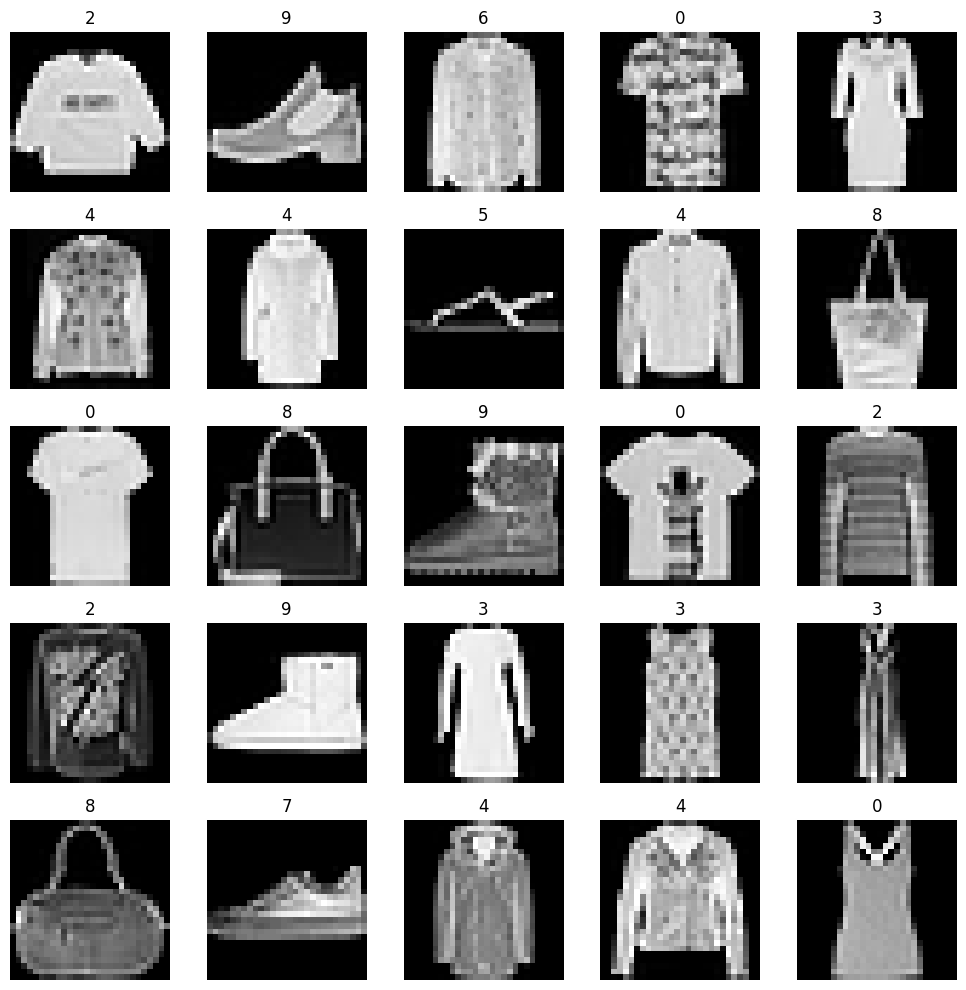

In [4]:
# Извлечение меток и пикселей
labels = dfTrain['label'].values
pixels = dfTrain.drop(['label', 'Id'], axis=1).values  # Удаляем столбцы 'label' и 'Id'

# Проверка формы данных
print("Количество изображений:", pixels.shape[0])
print("Размер изображений:", pixels.shape[1])  # Должно быть 784 (28x28)


# Отображаем 25 случайных изображений
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(pixels[i].reshape(28, 28), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
def prepare_data(pixels):
    # Преобразуем изображения в плоский формат и масштабируем
    x_flat = pixels.reshape(-1, 28*28).astype(float)
    scaler = StandardScaler()
    x_flat = scaler.fit_transform(x_flat)
    
    return x_flat

In [6]:

X_train, X_test, y_train, y_test = train_test_split(prepare_data(pixels), labels, test_size=0.2, random_state=42)

# Создаем и обучаем модель с увеличенным max_iter
clf = LogisticRegression(solver="lbfgs", max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

KeyboardInterrupt: 

In [ ]:
clf.fit(prepare_data(pixels), labels)
y_pred = clf.predict(prepare_data(dfTest))

In [ ]:
submission = pd.DataFrame({
    'Id': range(len(y_pred)),
    'label': y_pred
})

# Сохраняем в CSV файл (без индексов)
submission.to_csv('submission.csv', index=False)

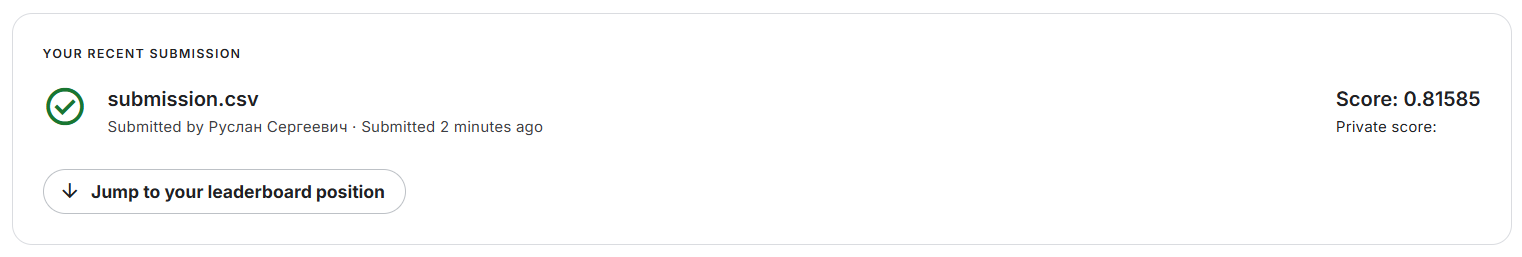

### Первый эксперимент с классическими методами маминого обучения

#### Выводы использования LogisticRegression
Линейная регрессия показала результат R² = 0.81585, что является приемлемым, но не максимально возможным уровнем точности. Основное ограничение линейной регрессии - она может моделировать только линейные зависимости между признаками и целевой переменной. В реальных данных часто присутствуют сложные нелинейные взаимосвязи, которые линейная модель не может уловить.

Хоть и есть возможность улучшить результат используя методы классического маминого обучения. Но оптимальным решением будет использовать.
Глубокие нейронные сети обладают несколькими ключевыми преимуществами по сравнению с линейной регрессией:
1. Способность моделировать сложные нелинейные зависимости благодаря активационным функциям и многослойной структуре
2. Автоматическое выделение значимых признаков в процессе обучения
3. Устойчивость к мультиколлинеарности (в разумных пределах)
4. Возможность обработки различных типов данных (таблицы, изображения, текст)

#### Применениям модели глубокого маминого обучения

Для проверки было выбрано два типа нейронных сетей полносвязная нейронная и сверточная нейронная

1. Полносвязная нейронная сеть (Net)
Текущая архитектура:
- Четыре полносвязных слоя с уменьшающейся размерностью (784-512-256-128-10)
- Batch normalization после каждого скрытого слоя
- Dropout с вероятностью 0.3 для регуляризации
- Функция активации LeakyReLU (negative_slope=0.1)


2. Сверточная нейронная сеть (CNN)
Текущая архитектура:
- Два сверточных слоя (1-32-64) с ядром 3x3 и padding=1
- MaxPooling после каждого сверточного слоя
- Два полносвязных слоя (3136-128-10)


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Увеличенная архитектура с BatchNorm
        self.fc1 = nn.Linear(784, 512)
        self.bn1 = nn.BatchNorm1d(512)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        
        self.fc4 = nn.Linear(128, 10)
        
        # Регуляризация
        self.dropout = nn.Dropout(0.3)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.FloatTensor(x)
        
        x = self.activation(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        
        x = self.activation(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        
        x = self.activation(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        
        x = self.fc4(x)
        return x

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 64*7*7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt

def train(model, X, y, criterion, optimizer, num_epoch, X_val=None, y_val=None):
    '''
    Улучшенная функция обучения с визуализацией процесса
    
    args:
        model - модель нейронной сети
        X и y - обучающая выборка
        criterion - функция потерь
        optimizer - оптимизатор
        num_epoch - количество эпох обучения
        X_val, y_val - валидационные данные (опционально)
    '''
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    # Цикл обучения с прогресс-баром
    for epoch in tqdm(range(num_epoch), desc="Training"):
        # Переводим модель в режим обучения
        model.train()
        
        # Обнуляем градиенты
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, y)
        
        # Backward pass и оптимизация
        loss.backward()
        optimizer.step()
        
        # Сохраняем метрики
        train_losses.append(loss.item())
        
        # Вычисляем accuracy на обучающей выборке
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y).sum().item()
        train_accuracy = correct / y.size(0)
        train_accuracies.append(train_accuracy)
        
        # Валидация (если предоставлены данные)
        if X_val is not None and y_val is not None:
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val)
                val_loss = criterion(val_outputs, y_val)
                val_losses.append(val_loss.item())
                
                _, val_predicted = torch.max(val_outputs.data, 1)
                val_correct = (val_predicted == y_val).sum().item()
                val_accuracy = val_correct / y_val.size(0)
                val_accuracies.append(val_accuracy)
            
            model.train()
        
        # Выводим статистику каждые N эпох
        if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == num_epoch - 1:
            print(f'Epoch {epoch + 1}/{num_epoch}')
            print(f'Train Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}')
            if X_val is not None and y_val is not None:
                print(f'Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}')
            print('-' * 30)
    
    # Визуализация процесса обучения
    plt.figure(figsize=(12, 5))
    
    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Ошибка на обучении')
    if val_losses:
        plt.plot(val_losses, label='Ошибка на валидации')
    plt.title('Функция потерь по эпохам')
    plt.xlabel('Эпоха')
    plt.ylabel('Ошибка')
    plt.legend()
    
    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Точность на обучении')
    if val_accuracies:
        plt.plot(val_accuracies, label='Точность на валидации')
    plt.title('Точность по эпохам')
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model

Был использован пример из лекции для обучения нейронной сети по эпохам, а также улучшена визуализация ошибки и функции потерь

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(prepare_data(pixels), labels, test_size=0.2, random_state=42)

# Преобразуем данные в тензоры
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_test).to(device)
y_val_tensor = torch.LongTensor(y_test).to(device)
X = torch.FloatTensor(prepare_data(pixels)).to(device)
Y = torch.LongTensor(labels).to(device)


print(f"X_train shape: {X_train_tensor.shape}")
print(f"y_train shape: {y_train_tensor.shape}")
print(f"X_train shape: {X_val_tensor.shape}")
print(f"y_train shape: {y_val_tensor.shape}")

X_train shape: torch.Size([13631, 784])
y_train shape: torch.Size([13631])
X_train shape: torch.Size([3408, 784])
y_train shape: torch.Size([3408])


Было протестировано несколько комбинаций архитектур нейронных сетей и методов оптимизации. Наилучший результат показала модель CNN с оптимизатором AdamW.

Training:   0%|          | 1/200 [00:00<02:32,  1.30it/s]

Epoch 1/200
Train Loss: 2.3161, Accuracy: 0.0911
Val Loss: 2.1270, Val Accuracy: 0.4727
------------------------------


Training:   5%|▌         | 10/200 [00:06<01:55,  1.65it/s]

Epoch 10/200
Train Loss: 1.2369, Accuracy: 0.7274
Val Loss: 1.2210, Val Accuracy: 0.7453
------------------------------


Training:  10%|█         | 20/200 [00:12<01:48,  1.66it/s]

Epoch 20/200
Train Loss: 1.0160, Accuracy: 0.7886
Val Loss: 1.0221, Val Accuracy: 0.7917
------------------------------


Training:  15%|█▌        | 30/200 [00:18<01:44,  1.63it/s]

Epoch 30/200
Train Loss: 0.9391, Accuracy: 0.8137
Val Loss: 0.9509, Val Accuracy: 0.8151
------------------------------


Training:  20%|██        | 40/200 [00:24<01:36,  1.66it/s]

Epoch 40/200
Train Loss: 0.8884, Accuracy: 0.8390
Val Loss: 0.9038, Val Accuracy: 0.8336
------------------------------


Training:  25%|██▌       | 50/200 [00:30<01:32,  1.63it/s]

Epoch 50/200
Train Loss: 0.8513, Accuracy: 0.8561
Val Loss: 0.8724, Val Accuracy: 0.8465
------------------------------


Training:  30%|███       | 60/200 [00:36<01:26,  1.61it/s]

Epoch 60/200
Train Loss: 0.8235, Accuracy: 0.8667
Val Loss: 0.8482, Val Accuracy: 0.8521
------------------------------


Training:  35%|███▌      | 70/200 [00:42<01:20,  1.62it/s]

Epoch 70/200
Train Loss: 0.8004, Accuracy: 0.8755
Val Loss: 0.8293, Val Accuracy: 0.8603
------------------------------


Training:  40%|████      | 80/200 [00:49<01:14,  1.60it/s]

Epoch 80/200
Train Loss: 0.7846, Accuracy: 0.8829
Val Loss: 0.8191, Val Accuracy: 0.8624
------------------------------


Training:  45%|████▌     | 90/200 [00:55<01:10,  1.56it/s]

Epoch 90/200
Train Loss: 0.7719, Accuracy: 0.8879
Val Loss: 0.8076, Val Accuracy: 0.8703
------------------------------


Training:  50%|█████     | 100/200 [01:01<01:02,  1.59it/s]

Epoch 100/200
Train Loss: 0.7599, Accuracy: 0.8933
Val Loss: 0.7975, Val Accuracy: 0.8750
------------------------------


Training:  55%|█████▌    | 110/200 [01:08<00:57,  1.55it/s]

Epoch 110/200
Train Loss: 0.7458, Accuracy: 0.8996
Val Loss: 0.7898, Val Accuracy: 0.8800
------------------------------


Training:  60%|██████    | 120/200 [01:14<00:50,  1.57it/s]

Epoch 120/200
Train Loss: 0.7348, Accuracy: 0.9055
Val Loss: 0.7828, Val Accuracy: 0.8817
------------------------------


Training:  65%|██████▌   | 130/200 [01:21<00:47,  1.49it/s]

Epoch 130/200
Train Loss: 0.7344, Accuracy: 0.9067
Val Loss: 0.7837, Val Accuracy: 0.8829
------------------------------


Training:  70%|███████   | 140/200 [01:27<00:40,  1.49it/s]

Epoch 140/200
Train Loss: 0.7158, Accuracy: 0.9162
Val Loss: 0.7718, Val Accuracy: 0.8870
------------------------------


Training:  75%|███████▌  | 150/200 [01:34<00:31,  1.57it/s]

Epoch 150/200
Train Loss: 0.7147, Accuracy: 0.9165
Val Loss: 0.7737, Val Accuracy: 0.8888
------------------------------


Training:  80%|████████  | 160/200 [01:40<00:25,  1.55it/s]

Epoch 160/200
Train Loss: 0.7005, Accuracy: 0.9237
Val Loss: 0.7664, Val Accuracy: 0.8888
------------------------------


Training:  85%|████████▌ | 170/200 [01:46<00:18,  1.60it/s]

Epoch 170/200
Train Loss: 0.6928, Accuracy: 0.9274
Val Loss: 0.7626, Val Accuracy: 0.8911
------------------------------


Training:  90%|█████████ | 180/200 [01:53<00:12,  1.60it/s]

Epoch 180/200
Train Loss: 0.6889, Accuracy: 0.9296
Val Loss: 0.7663, Val Accuracy: 0.8917
------------------------------


Training:  95%|█████████▌| 190/200 [01:59<00:06,  1.54it/s]

Epoch 190/200
Train Loss: 0.6806, Accuracy: 0.9348
Val Loss: 0.7563, Val Accuracy: 0.8941
------------------------------


Training: 100%|██████████| 200/200 [02:05<00:00,  1.59it/s]

Epoch 200/200
Train Loss: 0.6879, Accuracy: 0.9306
Val Loss: 0.7634, Val Accuracy: 0.8944
------------------------------


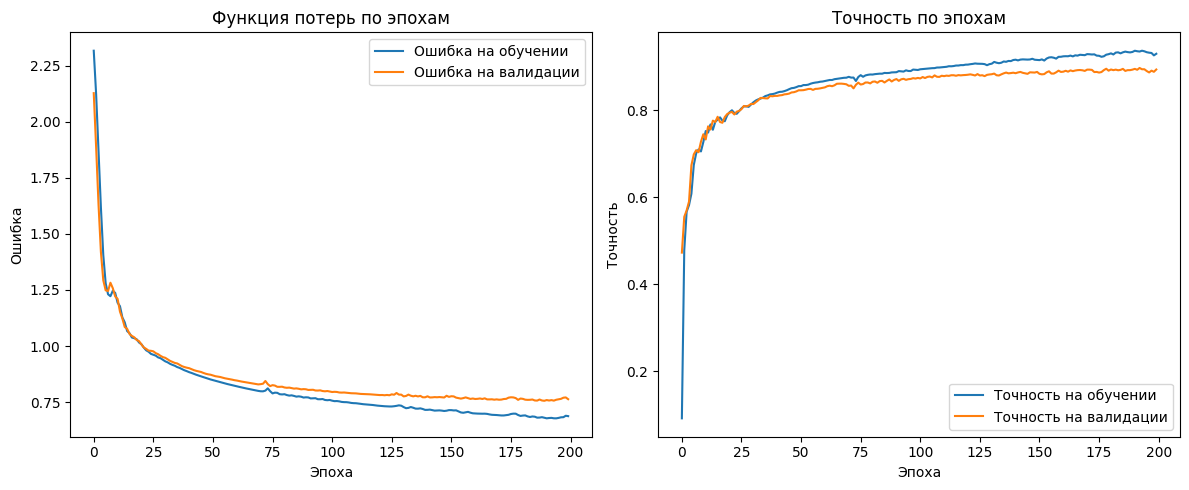

In [ ]:
# Если y_train_tensor имеет размер [n_samples, 1], нужно сжать до [n_samples]
if y_train_tensor.dim() == 2 and y_train_tensor.shape[1] == 1:
    y_train_tensor = y_train_tensor.squeeze()

# Инициализация модели, функции потерь и оптимизатора
model = CNN().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
model = train(model, X_train_tensor, y_train_tensor, 
             criterion, optimizer, num_epoch=200,
             X_val=X_val_tensor, y_val=y_val_tensor)

Training:   0%|          | 1/1000 [00:02<33:40,  2.02s/it]

Epoch 1/1000
Train Loss: 2.3001, Accuracy: 0.1525
------------------------------


Training:   1%|          | 10/1000 [00:14<24:08,  1.46s/it]

Epoch 10/1000
Train Loss: 0.7574, Accuracy: 0.7290
------------------------------


Training:   2%|▏         | 20/1000 [00:27<21:03,  1.29s/it]

Epoch 20/1000
Train Loss: 0.6320, Accuracy: 0.7747
------------------------------


Training:   3%|▎         | 30/1000 [00:40<21:31,  1.33s/it]

Epoch 30/1000
Train Loss: 0.5364, Accuracy: 0.8000
------------------------------


Training:   4%|▍         | 40/1000 [00:54<22:02,  1.38s/it]

Epoch 40/1000
Train Loss: 0.4892, Accuracy: 0.8237
------------------------------


Training:   5%|▌         | 50/1000 [01:08<21:16,  1.34s/it]

Epoch 50/1000
Train Loss: 0.4472, Accuracy: 0.8385
------------------------------


Training:   6%|▌         | 60/1000 [01:21<22:23,  1.43s/it]

Epoch 60/1000
Train Loss: 0.4142, Accuracy: 0.8508
------------------------------


Training:   7%|▋         | 70/1000 [01:35<20:49,  1.34s/it]

Epoch 70/1000
Train Loss: 0.3876, Accuracy: 0.8619
------------------------------


Training:   8%|▊         | 80/1000 [01:48<20:13,  1.32s/it]

Epoch 80/1000
Train Loss: 0.3653, Accuracy: 0.8685
------------------------------


Training:   9%|▉         | 90/1000 [02:02<20:32,  1.35s/it]

Epoch 90/1000
Train Loss: 0.3454, Accuracy: 0.8761
------------------------------


Training:  10%|█         | 100/1000 [02:16<20:08,  1.34s/it]

Epoch 100/1000
Train Loss: 0.3273, Accuracy: 0.8844
------------------------------


Training:  11%|█         | 110/1000 [02:29<20:02,  1.35s/it]

Epoch 110/1000
Train Loss: 0.3110, Accuracy: 0.8893
------------------------------


Training:  12%|█▏        | 120/1000 [02:42<18:54,  1.29s/it]

Epoch 120/1000
Train Loss: 0.3013, Accuracy: 0.8934
------------------------------


Training:  13%|█▎        | 130/1000 [02:55<18:45,  1.29s/it]

Epoch 130/1000
Train Loss: 0.2856, Accuracy: 0.9000
------------------------------


Training:  14%|█▍        | 140/1000 [03:09<18:42,  1.31s/it]

Epoch 140/1000
Train Loss: 0.2730, Accuracy: 0.9052
------------------------------


Training:  15%|█▌        | 150/1000 [03:22<18:09,  1.28s/it]

Epoch 150/1000
Train Loss: 0.2611, Accuracy: 0.9100
------------------------------


Training:  16%|█▌        | 160/1000 [03:35<17:38,  1.26s/it]

Epoch 160/1000
Train Loss: 0.2647, Accuracy: 0.9063
------------------------------


Training:  17%|█▋        | 170/1000 [03:48<18:22,  1.33s/it]

Epoch 170/1000
Train Loss: 0.2445, Accuracy: 0.9163
------------------------------


Training:  18%|█▊        | 180/1000 [04:01<17:59,  1.32s/it]

Epoch 180/1000
Train Loss: 0.2322, Accuracy: 0.9205
------------------------------


Training:  19%|█▉        | 190/1000 [04:15<17:39,  1.31s/it]

Epoch 190/1000
Train Loss: 0.2388, Accuracy: 0.9145
------------------------------


Training:  20%|██        | 200/1000 [04:27<16:54,  1.27s/it]

Epoch 200/1000
Train Loss: 0.2243, Accuracy: 0.9233
------------------------------


Training:  21%|██        | 210/1000 [04:41<17:36,  1.34s/it]

Epoch 210/1000
Train Loss: 0.2082, Accuracy: 0.9287
------------------------------


Training:  22%|██▏       | 220/1000 [04:54<16:36,  1.28s/it]

Epoch 220/1000
Train Loss: 0.2006, Accuracy: 0.9314
------------------------------


Training:  23%|██▎       | 230/1000 [05:07<16:36,  1.29s/it]

Epoch 230/1000
Train Loss: 0.2147, Accuracy: 0.9239
------------------------------


Training:  24%|██▍       | 240/1000 [05:21<16:31,  1.30s/it]

Epoch 240/1000
Train Loss: 0.1896, Accuracy: 0.9358
------------------------------


Training:  25%|██▌       | 250/1000 [05:33<16:10,  1.29s/it]

Epoch 250/1000
Train Loss: 0.1866, Accuracy: 0.9373
------------------------------


Training:  26%|██▌       | 260/1000 [05:46<15:23,  1.25s/it]

Epoch 260/1000
Train Loss: 0.1772, Accuracy: 0.9410
------------------------------


Training:  27%|██▋       | 270/1000 [05:59<16:27,  1.35s/it]

Epoch 270/1000
Train Loss: 0.1718, Accuracy: 0.9433
------------------------------


Training:  28%|██▊       | 280/1000 [06:12<15:37,  1.30s/it]

Epoch 280/1000
Train Loss: 0.1900, Accuracy: 0.9299
------------------------------


Training:  29%|██▉       | 290/1000 [06:26<14:50,  1.25s/it]

Epoch 290/1000
Train Loss: 0.1604, Accuracy: 0.9465
------------------------------


Training:  30%|███       | 300/1000 [06:38<15:10,  1.30s/it]

Epoch 300/1000
Train Loss: 0.1540, Accuracy: 0.9499
------------------------------


Training:  31%|███       | 310/1000 [06:53<15:26,  1.34s/it]

Epoch 310/1000
Train Loss: 0.1470, Accuracy: 0.9532
------------------------------


Training:  32%|███▏      | 320/1000 [07:05<14:17,  1.26s/it]

Epoch 320/1000
Train Loss: 0.1539, Accuracy: 0.9446
------------------------------


Training:  33%|███▎      | 330/1000 [07:18<14:31,  1.30s/it]

Epoch 330/1000
Train Loss: 0.2006, Accuracy: 0.9250
------------------------------


Training:  34%|███▍      | 340/1000 [07:32<14:13,  1.29s/it]

Epoch 340/1000
Train Loss: 0.1667, Accuracy: 0.9396
------------------------------


Training:  35%|███▌      | 350/1000 [07:45<13:59,  1.29s/it]

Epoch 350/1000
Train Loss: 0.1393, Accuracy: 0.9538
------------------------------


Training:  36%|███▌      | 360/1000 [07:58<13:44,  1.29s/it]

Epoch 360/1000
Train Loss: 0.1317, Accuracy: 0.9575
------------------------------


Training:  37%|███▋      | 370/1000 [08:11<13:30,  1.29s/it]

Epoch 370/1000
Train Loss: 0.1234, Accuracy: 0.9601
------------------------------


Training:  38%|███▊      | 380/1000 [08:24<13:44,  1.33s/it]

Epoch 380/1000
Train Loss: 0.1177, Accuracy: 0.9631
------------------------------


Training:  39%|███▉      | 390/1000 [08:37<12:50,  1.26s/it]

Epoch 390/1000
Train Loss: 0.1127, Accuracy: 0.9657
------------------------------


Training:  40%|████      | 400/1000 [08:50<12:58,  1.30s/it]

Epoch 400/1000
Train Loss: 0.1082, Accuracy: 0.9679
------------------------------


Training:  41%|████      | 410/1000 [09:04<13:35,  1.38s/it]

Epoch 410/1000
Train Loss: 0.1192, Accuracy: 0.9602
------------------------------


Training:  42%|████▏     | 420/1000 [09:17<12:19,  1.27s/it]

Epoch 420/1000
Train Loss: 0.1243, Accuracy: 0.9580
------------------------------


Training:  43%|████▎     | 430/1000 [09:30<11:56,  1.26s/it]

Epoch 430/1000
Train Loss: 0.1077, Accuracy: 0.9652
------------------------------


Training:  44%|████▍     | 440/1000 [09:43<12:14,  1.31s/it]

Epoch 440/1000
Train Loss: 0.0998, Accuracy: 0.9695
------------------------------


Training:  45%|████▌     | 450/1000 [09:56<11:52,  1.29s/it]

Epoch 450/1000
Train Loss: 0.0938, Accuracy: 0.9723
------------------------------


Training:  46%|████▌     | 460/1000 [10:09<11:59,  1.33s/it]

Epoch 460/1000
Train Loss: 0.0894, Accuracy: 0.9746
------------------------------


Training:  47%|████▋     | 470/1000 [10:22<11:21,  1.29s/it]

Epoch 470/1000
Train Loss: 0.0855, Accuracy: 0.9768
------------------------------


Training:  48%|████▊     | 480/1000 [10:35<11:14,  1.30s/it]

Epoch 480/1000
Train Loss: 0.0819, Accuracy: 0.9779
------------------------------


Training:  49%|████▉     | 490/1000 [10:48<10:38,  1.25s/it]

Epoch 490/1000
Train Loss: 0.0785, Accuracy: 0.9792
------------------------------


Training:  50%|█████     | 500/1000 [11:01<10:45,  1.29s/it]

Epoch 500/1000
Train Loss: 0.0778, Accuracy: 0.9781
------------------------------


Training:  51%|█████     | 510/1000 [11:15<11:20,  1.39s/it]

Epoch 510/1000
Train Loss: 0.2188, Accuracy: 0.9254
------------------------------


Training:  52%|█████▏    | 520/1000 [11:28<09:44,  1.22s/it]

Epoch 520/1000
Train Loss: 0.1224, Accuracy: 0.9545
------------------------------


Training:  53%|█████▎    | 530/1000 [11:40<10:05,  1.29s/it]

Epoch 530/1000
Train Loss: 0.0910, Accuracy: 0.9717
------------------------------


Training:  54%|█████▍    | 540/1000 [11:55<09:44,  1.27s/it]

Epoch 540/1000
Train Loss: 0.0798, Accuracy: 0.9776
------------------------------


Training:  55%|█████▌    | 550/1000 [12:07<09:11,  1.23s/it]

Epoch 550/1000
Train Loss: 0.0741, Accuracy: 0.9792
------------------------------


Training:  56%|█████▌    | 560/1000 [12:20<10:25,  1.42s/it]

Epoch 560/1000
Train Loss: 0.0674, Accuracy: 0.9826
------------------------------


Training:  57%|█████▋    | 570/1000 [12:33<09:04,  1.27s/it]

Epoch 570/1000
Train Loss: 0.0633, Accuracy: 0.9840
------------------------------


Training:  58%|█████▊    | 580/1000 [12:46<09:03,  1.29s/it]

Epoch 580/1000
Train Loss: 0.0602, Accuracy: 0.9852
------------------------------


Training:  59%|█████▉    | 590/1000 [13:00<08:54,  1.30s/it]

Epoch 590/1000
Train Loss: 0.0575, Accuracy: 0.9859
------------------------------


Training:  60%|██████    | 600/1000 [13:12<07:57,  1.19s/it]

Epoch 600/1000
Train Loss: 0.0550, Accuracy: 0.9867
------------------------------


Training:  61%|██████    | 610/1000 [13:27<11:06,  1.71s/it]

Epoch 610/1000
Train Loss: 0.0526, Accuracy: 0.9876
------------------------------


Training:  62%|██████▏   | 620/1000 [13:39<07:44,  1.22s/it]

Epoch 620/1000
Train Loss: 0.0504, Accuracy: 0.9884
------------------------------


Training:  63%|██████▎   | 630/1000 [13:52<07:38,  1.24s/it]

Epoch 630/1000
Train Loss: 0.0485, Accuracy: 0.9893
------------------------------


Training:  64%|██████▍   | 640/1000 [14:05<08:02,  1.34s/it]

Epoch 640/1000
Train Loss: 0.0488, Accuracy: 0.9890
------------------------------


Training:  65%|██████▌   | 650/1000 [14:18<07:28,  1.28s/it]

Epoch 650/1000
Train Loss: 0.3400, Accuracy: 0.8980
------------------------------


Training:  66%|██████▌   | 660/1000 [14:32<08:54,  1.57s/it]

Epoch 660/1000
Train Loss: 0.1757, Accuracy: 0.9367
------------------------------


Training:  67%|██████▋   | 670/1000 [14:45<07:06,  1.29s/it]

Epoch 670/1000
Train Loss: 0.1566, Accuracy: 0.9421
------------------------------


Training:  68%|██████▊   | 680/1000 [14:57<06:51,  1.29s/it]

Epoch 680/1000
Train Loss: 0.1132, Accuracy: 0.9630
------------------------------


Training:  69%|██████▉   | 690/1000 [15:12<07:02,  1.36s/it]

Epoch 690/1000
Train Loss: 0.0889, Accuracy: 0.9707
------------------------------


Training:  70%|███████   | 700/1000 [15:24<06:20,  1.27s/it]

Epoch 700/1000
Train Loss: 0.0718, Accuracy: 0.9788
------------------------------


Training:  71%|███████   | 710/1000 [15:38<08:02,  1.67s/it]

Epoch 710/1000
Train Loss: 0.0630, Accuracy: 0.9815
------------------------------


Training:  72%|███████▏  | 720/1000 [15:50<05:40,  1.22s/it]

Epoch 720/1000
Train Loss: 0.0567, Accuracy: 0.9849
------------------------------


Training:  73%|███████▎  | 730/1000 [16:03<05:43,  1.27s/it]

Epoch 730/1000
Train Loss: 0.0520, Accuracy: 0.9870
------------------------------


Training:  74%|███████▍  | 740/1000 [16:17<06:00,  1.39s/it]

Epoch 740/1000
Train Loss: 0.0484, Accuracy: 0.9881
------------------------------


Training:  75%|███████▌  | 750/1000 [16:29<05:11,  1.25s/it]

Epoch 750/1000
Train Loss: 0.0453, Accuracy: 0.9891
------------------------------


Training:  76%|███████▌  | 760/1000 [16:42<05:06,  1.28s/it]

Epoch 760/1000
Train Loss: 0.0428, Accuracy: 0.9901
------------------------------


Training:  77%|███████▋  | 770/1000 [16:56<04:45,  1.24s/it]

Epoch 770/1000
Train Loss: 0.0406, Accuracy: 0.9917
------------------------------


Training:  78%|███████▊  | 780/1000 [17:09<04:41,  1.28s/it]

Epoch 780/1000
Train Loss: 0.0386, Accuracy: 0.9927
------------------------------


Training:  79%|███████▉  | 790/1000 [17:22<04:49,  1.38s/it]

Epoch 790/1000
Train Loss: 0.0368, Accuracy: 0.9933
------------------------------


Training:  80%|████████  | 800/1000 [17:35<04:15,  1.28s/it]

Epoch 800/1000
Train Loss: 0.0352, Accuracy: 0.9935
------------------------------


Training:  81%|████████  | 810/1000 [17:48<04:02,  1.28s/it]

Epoch 810/1000
Train Loss: 0.0338, Accuracy: 0.9944
------------------------------


Training:  82%|████████▏ | 820/1000 [18:01<03:46,  1.26s/it]

Epoch 820/1000
Train Loss: 0.0324, Accuracy: 0.9948
------------------------------


Training:  83%|████████▎ | 830/1000 [18:14<03:38,  1.29s/it]

Epoch 830/1000
Train Loss: 0.0312, Accuracy: 0.9957
------------------------------


Training:  84%|████████▍ | 840/1000 [18:28<03:45,  1.41s/it]

Epoch 840/1000
Train Loss: 0.0300, Accuracy: 0.9960
------------------------------


Training:  85%|████████▌ | 850/1000 [18:41<03:09,  1.26s/it]

Epoch 850/1000
Train Loss: 0.0288, Accuracy: 0.9962
------------------------------


Training:  86%|████████▌ | 860/1000 [18:54<03:01,  1.30s/it]

Epoch 860/1000
Train Loss: 0.0278, Accuracy: 0.9962
------------------------------


Training:  87%|████████▋ | 870/1000 [19:08<02:53,  1.33s/it]

Epoch 870/1000
Train Loss: 0.0267, Accuracy: 0.9965
------------------------------


Training:  88%|████████▊ | 880/1000 [19:21<02:33,  1.28s/it]

Epoch 880/1000
Train Loss: 0.0257, Accuracy: 0.9968
------------------------------


Training:  89%|████████▉ | 890/1000 [19:34<02:20,  1.28s/it]

Epoch 890/1000
Train Loss: 0.0248, Accuracy: 0.9971
------------------------------


Training:  90%|█████████ | 900/1000 [19:46<02:08,  1.28s/it]

Epoch 900/1000
Train Loss: 0.0239, Accuracy: 0.9973
------------------------------


Training:  91%|█████████ | 910/1000 [19:59<01:57,  1.31s/it]

Epoch 910/1000
Train Loss: 0.0230, Accuracy: 0.9975
------------------------------


Training:  92%|█████████▏| 920/1000 [20:13<01:40,  1.26s/it]

Epoch 920/1000
Train Loss: 0.0222, Accuracy: 0.9979
------------------------------


Training:  93%|█████████▎| 930/1000 [20:26<01:30,  1.30s/it]

Epoch 930/1000
Train Loss: 0.0214, Accuracy: 0.9979
------------------------------


Training:  94%|█████████▍| 940/1000 [20:39<01:23,  1.40s/it]

Epoch 940/1000
Train Loss: 0.0206, Accuracy: 0.9981
------------------------------


Training:  95%|█████████▌| 950/1000 [20:52<01:04,  1.29s/it]

Epoch 950/1000
Train Loss: 0.0198, Accuracy: 0.9982
------------------------------


Training:  96%|█████████▌| 960/1000 [21:05<00:51,  1.29s/it]

Epoch 960/1000
Train Loss: 0.0191, Accuracy: 0.9984
------------------------------


Training:  97%|█████████▋| 970/1000 [21:19<00:39,  1.32s/it]

Epoch 970/1000
Train Loss: 0.0184, Accuracy: 0.9984
------------------------------


Training:  98%|█████████▊| 980/1000 [21:32<00:24,  1.25s/it]

Epoch 980/1000
Train Loss: 0.0178, Accuracy: 0.9984
------------------------------


Training:  99%|█████████▉| 990/1000 [21:45<00:14,  1.45s/it]

Epoch 990/1000
Train Loss: 0.0171, Accuracy: 0.9986
------------------------------


Training: 100%|██████████| 1000/1000 [21:58<00:00,  1.32s/it]

Epoch 1000/1000
Train Loss: 0.0165, Accuracy: 0.9987
------------------------------


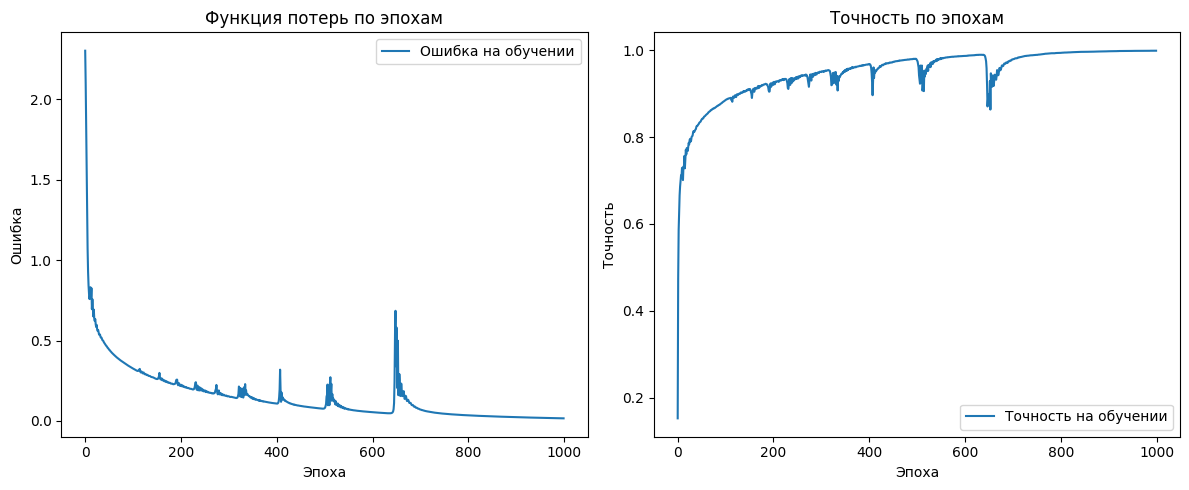

In [ ]:
# Если y_train_tensor имеет размер [n_samples, 1], нужно сжать до [n_samples]
if Y.dim() == 2 and Y.shape[1] == 1:
    Y = Y.squeeze()

# Инициализация модели, функции потерь и оптимизатора
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
model = train(model, X, Y, criterion, optimizer, num_epoch=1000)

In [ ]:
# Конвертируем данные в тензор и переносим на нужное устройство
if not isinstance(prepare_data(dfTest), torch.Tensor):
    test_data = torch.FloatTensor(prepare_data(dfTest))
test_data = test_data.to(device)


with torch.no_grad():
    outputs = model(test_data)
    probabilities = torch.softmax(outputs, dim=1)
    predicted_classes = torch.argmax(outputs, dim=1)
    # Переносим результаты обратно на CPU для numpy преобразования
    probabilities = probabilities.cpu().numpy()
    predicted_classes = predicted_classes.cpu().numpy()

# Вывод предсказаний
for i, (prob, cls) in enumerate(zip(probabilities, predicted_classes)):
    print(f"Пример {i+1}: Категория {cls} с вероятностью {prob[cls]:.4f}")

# Создаем DataFrame для submission 
submission = pd.DataFrame({
    'Id': range(0, len(predicted_classes)),  
    'label': predicted_classes
})


submission.to_csv('submission2.csv', index=False)
print("Файл submission.csv успешно сохранен!")


Пример 1: Категория 0 с вероятностью 1.0000
Пример 2: Категория 1 с вероятностью 1.0000
Пример 3: Категория 2 с вероятностью 0.8989
Пример 4: Категория 6 с вероятностью 0.9917
Пример 5: Категория 3 с вероятностью 0.9567
Пример 6: Категория 6 с вероятностью 0.9940
Пример 7: Категория 8 с вероятностью 1.0000
Пример 8: Категория 6 с вероятностью 0.9095
Пример 9: Категория 5 с вероятностью 1.0000
Пример 10: Категория 0 с вероятностью 1.0000
Пример 11: Категория 3 с вероятностью 1.0000
Пример 12: Категория 2 с вероятностью 0.9536
Пример 13: Категория 4 с вероятностью 0.9954
Пример 14: Категория 6 с вероятностью 0.9999
Пример 15: Категория 8 с вероятностью 1.0000
Пример 16: Категория 5 с вероятностью 1.0000
Пример 17: Категория 4 с вероятностью 0.9218
Пример 18: Категория 3 с вероятностью 1.0000
Пример 19: Категория 6 с вероятностью 0.9998
Пример 20: Категория 4 с вероятностью 0.9998
Пример 21: Категория 4 с вероятностью 0.9994
Пример 22: Категория 4 с вероятностью 1.0000
Пример 23: Категори

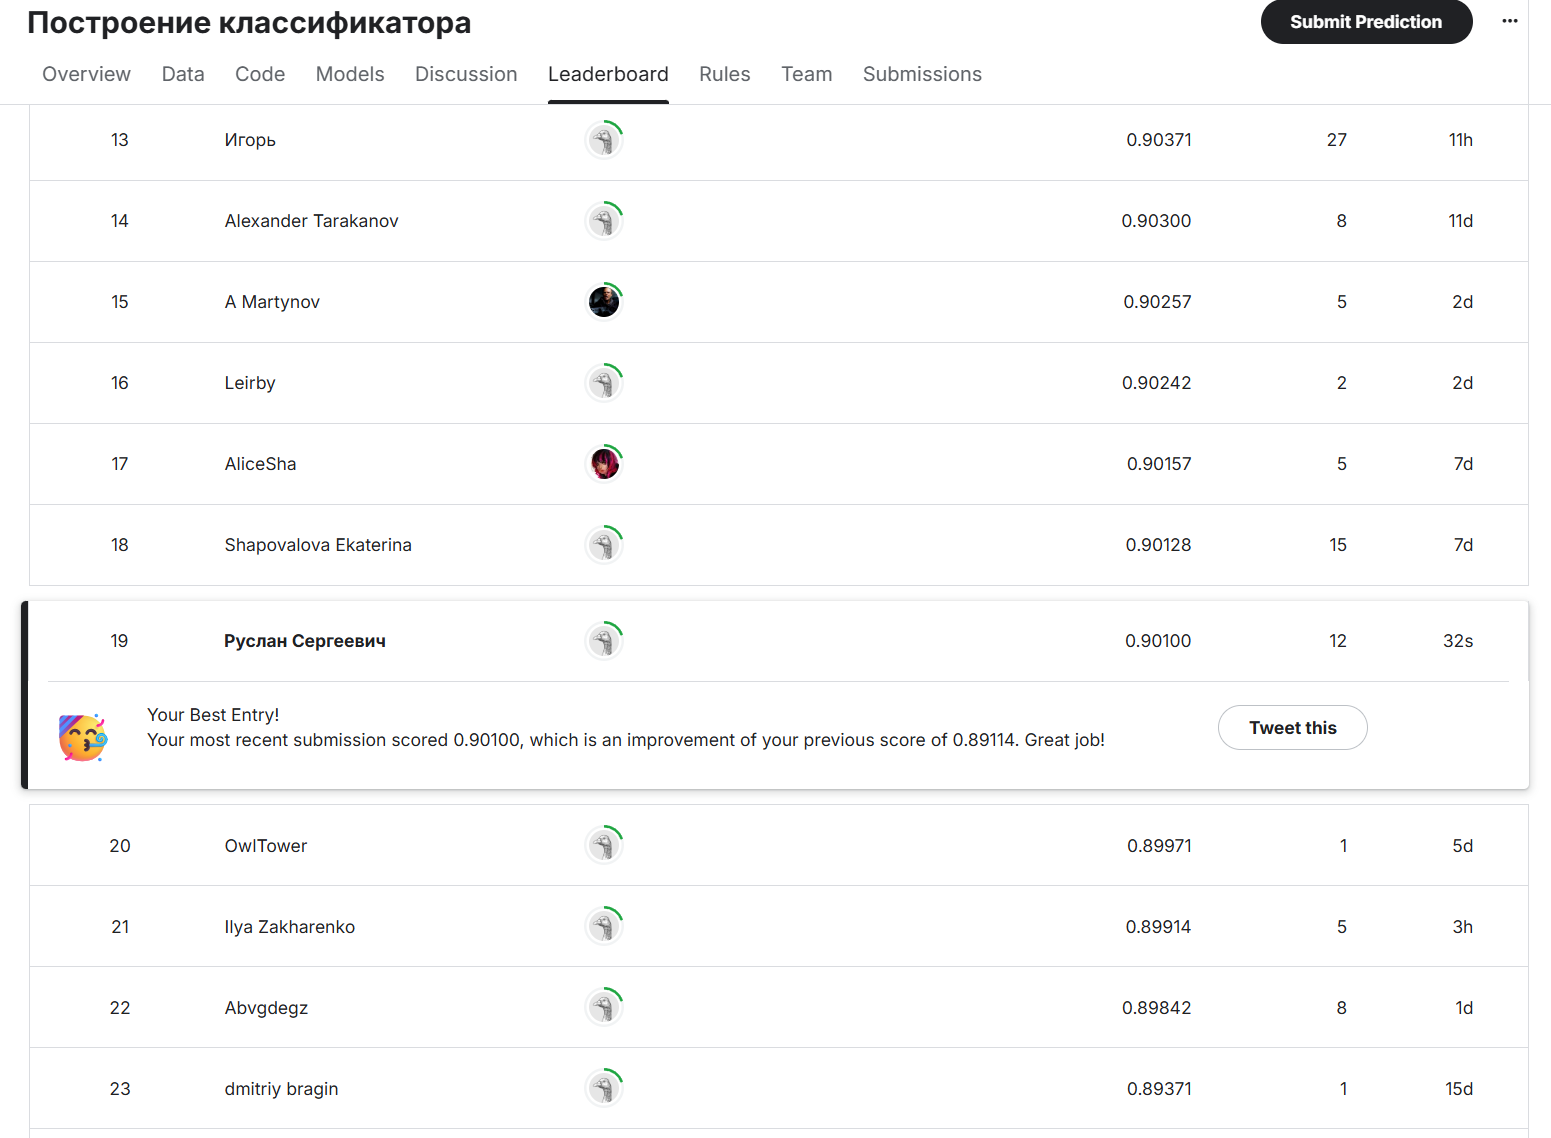

**Вывод по экспериментам:**  

Наилучший результат показала CNN с оптимизатором AdamW:  
- **Train Accuracy:** 93.06%  
- **Val Accuracy:** 89.44%  
- **Test Score (Kaggle):** 90.10%  

Модель демонстрирует хорошую сходимость с умеренным переобучением (разница Train/Val ~3.6%). Результат на тестовых данных подтверждает устойчивость модели (90.1% accuracy). Для дальнейшего улучшения можно попробовать:  
- регуляризацию (больший Dropout, L2),  
- аугментацию данных,  
- тонкую настройку гиперпараметров.